### Importing Required Modules
Let's start by importing essential classes and functions we will use later on

In [127]:
from tangelo import SecondQuantizedMolecule
from tangelo.algorithms import VQESolver, CCSDSolver
import numpy as np
import matplotlib.pyplot as plt
from adjustText import adjust_text

### Setting Up Timeout Method
To prevent our functions from running for way too long, we define utilities to limit execution time. This helps in achieving most accurate results the spesific backend used will allow.

In [128]:
import signal
from contextlib import contextmanager

class TimeoutException(Exception):
    pass

@contextmanager
def time_limit(seconds):

    def signal_handler(signum, frame):
        raise TimeoutException("Timed out!")

    # Register the signal function handler
    signal.signal(signal.SIGALRM, signal_handler)
    # Set the alarm
    signal.alarm(seconds)
    try:
        yield
    finally:
        # Disable the alarm
        signal.alarm(0)

def run_with_timeout(func, args=(), kwargs=None, timeout=10):
    if kwargs is None:
        kwargs = {}
    try:
        with time_limit(timeout):
            return func(*args, **kwargs)
    except TimeoutException:
        print(f"Function '{func.__name__}' timed out after {timeout} seconds.")
        return -1
    except Exception as e:
        print(f"Function '{func.__name__}' raised an exception: {e}")
        return -2

### Defining VQE Simulation Function
Here, we define a function to perform Variational Quantum Eigensolver (VQE) simulations on a given molecule. 

In [129]:
def vqe_simulate(second_quantized_mol):
    vqe_options = {"molecule": second_quantized_mol}
    vqe_solver = VQESolver(vqe_options)
    vqe_solver.build()
    return vqe_solver.simulate()

### Defining VQE Resource Function
This function returns the quantum resources required to run VQE for a molecule. This helps in understanding the feasibility of simulations on current quantum hardware.

In [130]:
def vqe_resources(second_quantized_mol):
    vqe_options = {"molecule": second_quantized_mol}
    vqe_solver = VQESolver(vqe_options)
    build = vqe_solver.build()
    return build, vqe_solver.get_resources()

### Defining Classical Simulation Function
We also simulate the molecule using classical methods like Coupled Cluster Singles and Doubles (CCSD) to compare with our quantum simulations.

In [131]:
def simulate_classically(second_quantized_mol):

    ccsd_solver = CCSDSolver(second_quantized_mol)
    energy_ccsd = ccsd_solver.simulate()
    return energy_ccsd

### Estimating VQE Resources with Different Qubit Mappings
This function explores how different qubit mappings (Jordan-Wigner, Bravyi-Kitaev, etc.) affect the resource requirements of the VQE algorithm.

In [132]:
def vqe_resources_with_mappings(molecule, ansatz):
 
    qubit_mappings = ['jw', 'bk', 'scbk']  # List of different qubit mappings
    resources_list = []

    for qm in qubit_mappings:
        # Define VQE options with the given molecule, ansatz, and current qubit mapping
        vqe_options = {"molecule": molecule, "ansatz": ansatz, "qubit_mapping": qm}
        vqe_solver = VQESolver(vqe_options)
        vqe_solver.build()
  

        # Get resources and store in the list
        resources = vqe_solver.get_resources()
        resources_list.append({"qubit_mapping": qm, "resources": resources})

    return resources_list

### Estimating VQE Resources with Different Ansatzes
Here, we evaluate how different ansatz choices impact the resource demands of the VQE algorithm, helping us choose the most efficient one.

In [133]:
def vqe_resources_with_ansatze(molecule, ansatze_list):

    resources_list = []

    for az in ansatze_list:
        # Define VQE options with the given molecule and ansatz
        vqe_options = {"molecule": molecule, "ansatz": az, "up_then_down": True}
        vqe_solver = VQESolver(vqe_options)
        vqe_solver.build()


        # Get resources and store in the list
        resources = vqe_solver.get_resources()
        resources_list.append({"ansatz": az, "resources": resources})

    return resources_list

### Printing Orbital Energies
This function displays the energies and occupation numbers of molecular orbitals, giving us insight into the electronic structure of the molecule.

In [134]:
def print_orbital_energies(molecule):

    orbital_energies = molecule.mo_energies
    occupations = molecule.mo_occ

    orbital_info = []
    for idx, (energy, occ) in enumerate(zip(orbital_energies, occupations)):
        orbital_info.append((idx, energy, occ))

    # Display orbital information
    print(f"Number of active electrons: {molecule.n_active_electrons}\n")
    print("Orbital Index | Occupation Number | Orbital Energy (Hartree)")
    print("------------------------------------------------------------")
    for idx, energy, occ in orbital_info:
        print(f"{idx:<13} {occ:<18} {energy}")
    

### 1D K-Means Clustering
We implement an efficient one-dimensional clustering algorithm to group orbitals based on their energies. This approach helps generate options for freezing orbitals, thereby simplifying calculations. Ideally, we would like to examine all possible configurations, but in most cases, the number of options becomes too large (n!). Therefore, clustering is necessary to focus on relevant and fewer options.

In [135]:
def KMeans1D_DP(data, K):
    
    n = len(data)
    # Sort data and keep track of original indices
    sorted_indices = np.argsort(data)
    sorted_data = data[sorted_indices]
    
    # Precompute cumulative sums and cumulative squared sums
    data_cumsum = np.zeros(n+1)
    data_sq_cumsum = np.zeros(n+1)
    for i in range(1, n+1):
        data_cumsum[i] = data_cumsum[i-1] + sorted_data[i-1]
        data_sq_cumsum[i] = data_sq_cumsum[i-1] + sorted_data[i-1]**2
    
    # Initialize the cost and segmentation arrays
    cost = np.full((n+1, K+1), np.inf)
    backtrack = np.zeros((n+1, K+1), dtype=int)
    
    cost[0][0] = 0  # Base case
    
    # Dynamic programming to compute optimal cost
    for i in range(1, n+1):
        for k in range(1, min(i, K)+1):
            for j in range(k-1, i):
                count = i - j
                sum_x = data_cumsum[i] - data_cumsum[j]
                sum_x_sq = data_sq_cumsum[i] - data_sq_cumsum[j]
                mean = sum_x / count
                ssd = sum_x_sq - 2 * mean * sum_x + count * mean**2
                total_cost = cost[j][k-1] + ssd
                if total_cost < cost[i][k]:
                    cost[i][k] = total_cost
                    backtrack[i][k] = j
    
    # Backtracking to assign labels
    labels = np.zeros(n, dtype=int)
    k = K
    i = n
    while k > 0:
        j = backtrack[i][k]
        labels[j:i] = k-1
        i = j
        k -=1
    
    # Map labels back to original data order
    original_labels = np.zeros(n, dtype=int)
    original_labels[sorted_indices] = labels
    
    return original_labels


### Generating Freeze Lists via Orbital Clustering
By clustering core and virtual orbitals using Kmeans, we create different freeze lists to explore how freezing certain orbitals affects resource requirements.

In [136]:
def generate_freeze_lists(molecule, k_core, k_virtual):

    orbital_energies = molecule.mo_energies
    occupations = molecule.mo_occ

    orbital_info = []
    for idx, (energy, occ) in enumerate(zip(orbital_energies, occupations)):
        orbital_info.append((idx, energy, occ))

    print(f"Number of active electrons: {molecule.n_active_electrons}")

    # Collect core orbitals (occupation == 2.0)
    core_indices = []
    core_energies = []
    for idx, energy, occ in orbital_info:
        if occ == 2.0:
            core_indices.append(idx)
            core_energies.append(energy)

    core_indices = np.array(core_indices)
    core_energies = np.array(core_energies)

    # Cluster core orbitals using dynamic programming
    if len(core_indices) == 0:
        print("No core orbitals to cluster.")
        core_clusters = {}
        core_cluster_order = []
    else:
        k_core = min(k_core, len(core_indices))
        core_labels = KMeans1D_DP(core_energies, k_core)
        # Group core orbitals by clusters
        core_clusters = {}
        for label in range(k_core):
            cluster_indices = core_indices[core_labels == label]
            core_clusters[label] = (cluster_indices)
        core_cluster_order = (range(k_core))
        # Print cluster info
        print(f"\nClustered core orbitals into {k_core} groups:")
        for label in core_cluster_order:
            indices = core_clusters[label]
            energies = [orbital_energies[i] for i in indices]
            print(f"Core Cluster {label+1}: Orbitals {indices}, Energies {energies}")

    # Collect virtual orbitals (occupation == 0.0)
    virtual_indices = []
    virtual_energies = []
    for idx, energy, occ in orbital_info:
        if occ == 0.0:
            virtual_indices.append(idx)
            virtual_energies.append(energy)

    virtual_indices = np.array(virtual_indices)
    virtual_energies = np.array(virtual_energies)

    # Cluster virtual orbitals using dynamic programming
    if len(virtual_indices) == 0:
        print("No virtual orbitals to cluster.")
        virtual_clusters = {}
        virtual_cluster_order = []
    else:
        k_virtual = min(k_virtual, len(virtual_indices))
        virtual_labels = KMeans1D_DP(virtual_energies, k_virtual)
        # Group virtual orbitals by clusters
        virtual_clusters = {}
        for label in range(k_virtual):
            cluster_indices = virtual_indices[virtual_labels == label]
            virtual_clusters[label] = (cluster_indices)
        virtual_cluster_order = (range(k_virtual))
        # Print cluster info
        print(f"\nClustered virtual orbitals into {k_virtual} groups:")
        for label in virtual_cluster_order:
            indices = virtual_clusters[label]
            energies = [orbital_energies[i] for i in indices]
            print(f"Virtual Cluster {label+1}: Orbitals {indices}, Energies {energies}")

    # Generate combinations according to the specified logic
    freeze_lists = []
    num_core_clusters = len(core_cluster_order)
    num_virtual_clusters = len(virtual_cluster_order)

    for c in range(1, num_core_clusters + 1):
        # Core clusters to include
        core_clusters_to_include = core_cluster_order[:c]
        core_orbitals_to_freeze = []
        for label in core_clusters_to_include:
            core_orbitals_to_freeze.extend(core_clusters[label])
        for v in range(0, num_virtual_clusters + 1):
            # Virtual clusters to include
            virtual_clusters_to_include = virtual_cluster_order[-v:] if v > 0 else []
            virtual_orbitals_to_freeze = []
            for label in virtual_clusters_to_include:
                virtual_orbitals_to_freeze.extend(virtual_clusters[label])
            freeze_list = core_orbitals_to_freeze + virtual_orbitals_to_freeze
            freeze_lists.append(freeze_list)
            print(f"\nGenerated freeze list with core clusters {core_clusters_to_include} and virtual clusters {virtual_clusters_to_include}")
            print(f"Freeze list orbitals: {freeze_list}")

    return freeze_lists


### Creating Resource Dictionaries for Different Freeze Lists
This function creates a dictionary of resource estimates for various freeze lists, helping us analyze how freezing different orbitals affects resource requirements.

In [137]:
def create_resources_dict(mol, charge, mol_spin, freeze_lists, timeout_duration=10):
    # Initialize the dictionary to store indexed entries
    frozen_molecules_dict = {}
    index = 0  # Start index at 0

    # Sort freeze_lists by length in descending order
    freeze_list_sorted = sorted(freeze_lists, key=len, reverse=True)

    for idx, freeze_list in enumerate(freeze_list_sorted, start=1):
        # Convert all elements in freeze_list to integers
        int_freeze_list = [int(x) for x in freeze_list]

        try:
            # Create a new SecondQuantizedMolecule with frozen orbitals
            frozen_orbs_mol = SecondQuantizedMolecule(
                mol,
                q=charge,
                spin=mol_spin,
                basis="LANL2DZ",
                frozen_orbitals=int_freeze_list
            )

            print(f"\nCreating frozen molecule for Freeze List {idx}: {int_freeze_list}")

            # Calculate resources with timeout
            result = run_with_timeout(vqe_resources, args=(frozen_orbs_mol,), timeout=timeout_duration)

            if result == -1:
                print(f"Stopping at Freeze List {int_freeze_list} due to timeout or error in resource calculation.")
                break
            elif result == -2:
                print(f"An error occurred while processing Freeze List: {int_freeze_list}")
            else:
                # Unpack the result correctly
                build, resources = result

                # Ensure no None values are included
                if resources is not None:
                    # Store the index as key and a dict of molecule, freeze_list, and resources as value
                    frozen_molecules_dict[index] = {
                        'molecule': frozen_orbs_mol,
                        'freeze_list': int_freeze_list,
                        'resources': resources
                    }
                    index += 1  # Increment the index
                else:
                    print(f"Resources for Freeze List {int_freeze_list} are None. Skipping.")

        except TypeError as e:
            print(f"TypeError for Freeze List {idx}: {e}")
        except Exception as e:
            print(f"Unexpected error for Freeze List {idx}: {e}")

    # Print the complete dictionary after processing
    print("\n--- Frozen Molecules Dictionary ---")
    for idx, res_dict in frozen_molecules_dict.items():
        print(f"Index {idx}: {res_dict}")

    return frozen_molecules_dict


### Visualizing VQE Resources
Using the collected data, we create a scatter plot to visualize how the number of frozen orbitals affects circuit width and depth, with annotations for the number of variational parameters.

In [167]:

def draw_resources(frozen_molecules_dict):
    # -----------------------------
    # Step 1: Prepare  Data
    # -----------------------------

    # Initialize lists to collect data
    num_frozen_orbitals_list = []
    circuit_widths_list = []
    circuit_depths_list = []
    vqe_variational_parameters_list = []

    for idx, data in frozen_molecules_dict.items():
        resources = data['resources']
        freeze_list = data['freeze_list']
        num_frozen_orbitals_list.append(len(freeze_list))
        circuit_widths_list.append(resources['circuit_width'])
        circuit_depths_list.append(resources['circuit_depth'])
        vqe_variational_parameters_list.append(resources['vqe_variational_parameters'])

    # Convert lists to NumPy arrays
    num_frozen_orbitals = np.array(num_frozen_orbitals_list)
    circuit_widths = np.array(circuit_widths_list)
    circuit_depths = np.array(circuit_depths_list)
    vqe_variational_parameters = np.array(vqe_variational_parameters_list)

    # -----------------------------
    # Step 2: Apply Jitter
    # -----------------------------

    jitter_x = 0.2  # Reduced jitter magnitude for cleaner plot
    jitter_y = 0.2

    np.random.seed(42)  # For reproducibility

    # Apply jitter to x and y coordinates
    num_frozen_orbitals_jittered = num_frozen_orbitals + np.random.uniform(-jitter_x, jitter_x, size=num_frozen_orbitals.shape)
    circuit_widths_jittered = circuit_widths + np.random.uniform(-jitter_y, jitter_y, size=circuit_widths.shape)

    # -----------------------------
    # Step 3: Create Scatter Plot
    # -----------------------------

    plt.figure(figsize=(12, 8))

    scatter = plt.scatter(
        num_frozen_orbitals_jittered,
        circuit_widths_jittered,
        c=circuit_depths,
        cmap='RdYlGn_r',  # Reversed diverging colormap: green (low) to red (high)
        s=100,
        alpha=0.7,
        edgecolor='k'  # Black edge for better marker distinction
    )

    # -----------------------------
    # Step 4: Add Colorbar
    # -----------------------------

    cbar = plt.colorbar(scatter)
    cbar.set_label('Circuit Depth', fontsize=12)
    cbar.ax.tick_params(labelsize=10)

    # -----------------------------
    # Step 5: Add Labels and Title
    # -----------------------------

    plt.xlabel('Number of Frozen Orbitals', fontsize=14)
    plt.ylabel('Circuit Width', fontsize=14)
    plt.title('Circuit Width vs. Number of Frozen Orbitals\nColored by Circuit Depth', fontsize=16)

    # -----------------------------
    # Step 6: Annotate Each Point
    # -----------------------------

    texts = []

    # Iterate over the jittered data and annotate
    for x, y, param in zip(num_frozen_orbitals_jittered, circuit_widths_jittered, vqe_variational_parameters):
        # Validate that param is a number and not NaN
        if param is not None and not (isinstance(param, float) and np.isnan(param)):
            texts.append(
                plt.text(
                    x, y,
                    f'{param}',
                    fontsize=9,
                    ha='center',
                    va='center',
                    color='black',
                    alpha=0.9,
                    bbox={'facecolor': 'white', 'alpha': 0.6, 'edgecolor': 'none', 'boxstyle': 'round,pad=0.2'}
                )
            )
        else:
            print(f"Invalid VQE Variational Parameter at ({x}, {y}): {param}")

    # -----------------------------
    # Step 7: Adjust Annotations
    # -----------------------------

    adjust_text(
        texts,
        arrowprops=dict(arrowstyle='-', color='gray', lw=0.5),
        only_move={'points': 'y', 'texts': 'y'},
        force_points=0.1,
        force_text=0.1,
        expand_points=(1.1, 1.2),
        expand_text=(1.1, 1.2),
        lim=50
    )

    # -----------------------------
    # Step 8: Final Touches
    # -----------------------------

    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()


### Running VQE Simulations with a Time Limit
This section of the project is dedicated to executing Variational Quantum Eigensolver (VQE) simulations on a set of molecular circuits. The primary goal is to efficiently estimate the ground state energies of these molecules by leveraging quantum computing resources while managing computational constraints.

In [139]:
def run_vqe_simulations(frozen_molecules_dict, timeout_duration=10):
    """
    Takes the dictionary from create_resources_dict, creates a list of (circuit width, energy) tuples,
    sorts it in ascending order of circuit width, and runs VQE simulations with timeout.
    Stops when a timeout is encountered.
    After the simulations, runs a classical simulation on the last successfully simulated molecule and prints the energy.
    Returns a list of (circuit_width, energy) tuples from VQE simulations.
    """
    # Create a list to hold (circuit width, molecule object)
    circuit_molecule_list = []
    # List to store the VQE results
    energies_vs_circuit_width = []
    # Variables to keep track of the last successful molecule
    last_successful_molecule = None
    last_circuit_width = None

    # Extract circuit width and molecule from the dictionary
    for idx, res_dict in frozen_molecules_dict.items():
        resources = res_dict['resources']
        molecule = res_dict['molecule']
        # Get circuit width from resources
        circuit_width = resources.get('circuit_width', None)  # Adjust the key based on your resources structure
        if circuit_width is not None:
            circuit_molecule_list.append((circuit_width, molecule))
        else:
            print(f"No circuit width found for index {idx}. Skipping.")

    # Sort the list by circuit width in ascending order
    circuit_molecule_list.sort(key=lambda x: x[0])

    # Run VQE simulations with timeout, starting from the smallest circuit width
    for circuit_width, molecule in circuit_molecule_list:
        print(f"Running VQE simulation for circuit width {circuit_width}")
        result = run_with_timeout(vqe_simulate, args=(molecule,), timeout=timeout_duration)
        if result == -1:
            print(f"Stopping at circuit width {circuit_width} due to timeout.")
            break
        elif result == -2:
            print(f"An error occurred during VQE simulation for circuit width {circuit_width}")
            continue  # Skip to the next molecule
        else:
            # Simulation succeeded
            energy = result  # Assuming vqe_simulate returns the energy
            print(f"VQE simulation successful for circuit width {circuit_width}. Energy: {energy}")
            energies_vs_circuit_width.append((circuit_width, energy))
            # Update the last successful molecule
            last_successful_molecule = molecule
            last_circuit_width = circuit_width

    # After the VQE simulations, run classical simulation on the last successful molecule
    if last_successful_molecule is not None:
        print(f"\nRunning classical simulation for the last successfully simulated molecule with circuit width {last_circuit_width}")
        classical_energy = simulate_classically(last_successful_molecule)
        print(f"Classical energy for circuit width {last_circuit_width}: {classical_energy}")
    else:
        print("No successful VQE simulations were performed before timeout.")

    print("\nVQE Energies vs. Circuit Width:")
    for cw, energy in energies_vs_circuit_width:
        print(f"Circuit Width: {cw}, VQE Energy: {energy}")

    return energies_vs_circuit_width


### Visualization of VQE Energies vs. Circuit Width
The plot_energies_vs_circuit_width function is designed to create a clear and detailed scatter plot that visualizes the relationship between the circuit width and the corresponding ground state energies obtained from Variational Quantum Eigensolver (VQE) simulations.

In [140]:
def plot_energies_vs_circuit_width(energies_vs_circuit_width):
    """
    Plots energies vs. circuit width as scatter points.
    Handles closely spaced energy values by appropriately scaling the y-axis.
    
    Parameters:
        energies_vs_circuit_width (list of tuples): List containing (circuit_width, energy) tuples.
    """
    if not energies_vs_circuit_width:
        print("No data to plot.")
        return
    
    # Unpack circuit widths and energies
    circuit_widths, energies = zip(*energies_vs_circuit_width)
    
    plt.figure(figsize=(12, 8))
    
    # Create scatter plot with larger markers
    plt.scatter(
        circuit_widths,
        energies,
        color='blue',
        alpha=0.7,
        edgecolors='w',
        s=200,  # Increased marker size from 100 to 200
        linewidth=1.5,
        marker='o'
    )
    
    # Alternate annotation positions to avoid overlap
    for idx, (cw, energy) in enumerate(energies_vs_circuit_width):
        offset = 10 if idx % 2 == 0 else -15  # Alternate between above and below the marker
        plt.annotate(
            f"{energy:.12f}",
            (cw, energy),
            textcoords="offset points",
            xytext=(0, offset),
            ha='center',
            fontsize=8,
            fontweight='bold',
            color='darkred'
        )
    
    # Labeling
    plt.xlabel('Circuit Width', fontsize=14)
    plt.ylabel('Energy', fontsize=14)
    plt.title('VQE Energies vs. Circuit Width', fontsize=16)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
    
    # Adjust y-axis limits for better visibility
    energy_min = min(energies)
    energy_max = max(energies)
    energy_range = energy_max - energy_min
    if energy_range == 0:
        # All energies are the same, set arbitrary range
        plt.ylim(energy_min - 1e-6, energy_max + 1e-6)
    else:
        plt.ylim(energy_min - 0.05 * energy_range, energy_max + 0.05 * energy_range)
    
    # Customize y-axis ticks for better readability
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.12f}'))
    # Alternatively, use scientific notation if values are very close
    # plt.gca().yaxis.set_major_formatter(ticker.FormatStrFormatter('%.6e'))
    
    plt.tight_layout()
    plt.show()

### Todo: 
finish implementing the hamaltonian function

In [141]:
def run_hamiltonian_simulations(frozen_molecules_dict, timeout_duration=10):
    """
    Takes the dictionary from create_resources_dict, runs hamiltonian_simulation on each molecule with timeout,
    and collects successful runs into a dictionary.
    The dictionary has indices starting from 0 as keys, and values are dictionaries containing the circuit width
    and the return value of hamiltonian_simulation.
    
    Parameters:
        frozen_molecules_dict (dict): Dictionary containing molecules and their resources.
        timeout_duration (int): Maximum allowed time for each hamiltonian_simulation run.
        
    Returns:
        results_dict (dict): Dictionary with indices as keys and dictionaries containing 'circuit_width' and 'result' as values.
    """
    # Create a list to hold (circuit width, molecule object)
    circuit_molecule_list = []
    
    # Extract circuit width and molecule from the dictionary
    for idx, res_dict in frozen_molecules_dict.items():
        resources = res_dict['resources']
        molecule = res_dict['molecule']
        # Get circuit width from resources
        circuit_width = resources.get('circuit_width', None)  # Adjust the key if needed
        if circuit_width is not None:
            circuit_molecule_list.append((circuit_width, molecule))
        else:
            print(f"No circuit width found for index {idx}. Skipping.")
    
    # Sort the list by circuit width in ascending order
    circuit_molecule_list.sort(key=lambda x: x[0])
    
    # Initialize the result dictionary
    results_dict = {}
    index = 0  # Start indices from 0
    
    # Run hamiltonian_simulation with timeout, starting from the smallest circuit width
    for circuit_width, molecule in circuit_molecule_list:
        print(f"Running hamiltonian_simulation for circuit width {circuit_width}")
        result = run_with_timeout(hamiltonian_simulation, args=(molecule,), timeout=timeout_duration)
        if result == -1:
            print(f"Stopping at circuit width {circuit_width} due to timeout.")
            break
        elif result == -2:
            print(f"An error occurred during hamiltonian_simulation for circuit width {circuit_width}")
            continue  # Skip to the next molecule
        else:
            # Simulation succeeded
            print(f"hamiltonian_simulation successful for circuit width {circuit_width}. Result: {result}")
            # Store the result in the dictionary
            results_dict[index] = {
                'circuit_width': circuit_width,
                'result': result
            }
            index += 1  # Increment the index
    
    # Return the results dictionary
    return results_dict


### Printing Molecule Properties
This function prints important properties of a molecule, giving us a quick overview of its characteristics.

In [142]:
def print_molecule_properties(name, molecule):
    print(f"=== {name} Properties ===")
    print(f"Charge (q): {molecule.q}")
    print(f"Spin (2S): {molecule.spin}")
    print(f"Number of Electrons: {molecule.n_electrons}")
    print(f"Number of Active Electrons: {molecule.n_active_electrons}")
    print(f"Basis Set: {molecule.basis}")
    print(f"Frozen Orbitals: {molecule.frozen_orbitals}")
    print("--------------------------\n")

### Defining Molecules for Simulation
In this section, we'll define the molecular structures we'll be working with:
Chromium (Cr): We'll explore two oxidation states of Chromium: +III (Cr₃⁺) and +VI (Cr₆⁺).
Nitrate (NO₃⁻): A polyatomic ion consisting of one nitrogen atom centrally bonded to three oxygen atoms in a trigonal planar arrangement.

In [162]:
# Define the Cr element
Cr= [['Cr', (0, 0, 0)]]


# Create a SecondQuantizedMolecule instance for Cr_VI
Cr_VI = SecondQuantizedMolecule(Cr, q=6, spin=0, basis="LANL2DZ", frozen_orbitals=None)

# Create a SecondQuantizedMolecule instance for Cr_III
Cr_III = SecondQuantizedMolecule(Cr, q=3, spin=3, basis="LANL2DZ", frozen_orbitals=None)

Nitrate = [
    ('N', (0.0, 0.0, 0.0)),
    ('O', (1.22, 0.0, 0.0)),
    ('O', (-0.61, 1.06, 0.0)),
    ('O', (-0.61, -1.06, 0.0))
]

# Create a SecondQuantizedMolecule instance for Nitrate
mol_Nitrate = SecondQuantizedMolecule(Nitrate, q=-1, spin=0, basis="sto-3g", frozen_orbitals=None)


print_molecule_properties("Cr_III", Cr_III)
print_molecule_properties("Cr_VI", Cr_VI)
print_molecule_properties("mol_Nitrate", mol_Nitrate)

=== Cr_III Properties ===
Charge (q): 3
Spin (2S): 3
Number of Electrons: 21
Number of Active Electrons: 21
Basis Set: LANL2DZ
Frozen Orbitals: None
--------------------------

=== Cr_VI Properties ===
Charge (q): 6
Spin (2S): 0
Number of Electrons: 18
Number of Active Electrons: 18
Basis Set: LANL2DZ
Frozen Orbitals: None
--------------------------

=== mol_Nitrate Properties ===
Charge (q): -1
Spin (2S): 0
Number of Electrons: 32
Number of Active Electrons: 32
Basis Set: sto-3g
Frozen Orbitals: None
--------------------------


### Exploring Orbital Energies
Understanding the orbital energies and their occupations gives us insight into the electronic structure of our molecules. In this part, we'll print out the energies and occupation numbers of the molecular orbitals for Chromium in both +III and +VI oxidation states. This information is crucial for determining which orbitals to freeze and cluster in subsequent simulations.

In [152]:
print_orbital_energies(Cr_III)
print_orbital_energies(Cr_VI)
print_orbital_energies(mol_Nitrate)


Number of active electrons: 21

Orbital Index | Occupation Number | Orbital Energy (Hartree)
------------------------------------------------------------
0             2.0                -12.450388167226931
1             2.0                -9.656066247751001
2             2.0                -9.656066241624856
3             2.0                -9.656066230973316
4             2.0                -6.4812268299810585
5             2.0                -6.481226823782232
6             2.0                -6.481226818353247
7             2.0                -6.479526796452701
8             2.0                -6.47952679219995
9             1.0                -1.88014821316846
10            1.0                -0.7975336327365674
11            1.0                -0.7975336228811852
12            0.0                -0.7535812772972836
13            0.0                -0.7535812694988463
14            0.0                -0.75358126377215
15            0.0                -0.7031960313224686
16        

### Generating Freeze Lists via Orbital Clustering
By clustering core (occupied) and virtual (unoccupied) orbitals, we can create different and hopefully efficient option for freeze lists. In this case we choose 8 orbital clusters for the core (separating to individual orbitals) and 4 clusters for the virtual orbitals. 


In [159]:
Cr_III_freeze_lists = generate_freeze_lists(Cr_III, 8, 4)
Cr_VI_freeze_lists = generate_freeze_lists(Cr_VI, 8, 4)
Nitrate_freeze_list = generate_freeze_lists(mol_Nitrate, 8, 4)

Number of active electrons: 21

Clustered core orbitals into 8 groups:
Core Cluster 1: Orbitals [0], Energies [-12.450388167226931]
Core Cluster 2: Orbitals [1], Energies [-9.656066247751001]
Core Cluster 3: Orbitals [2], Energies [-9.656066241624856]
Core Cluster 4: Orbitals [3], Energies [-9.656066230973316]
Core Cluster 5: Orbitals [4], Energies [-6.4812268299810585]
Core Cluster 6: Orbitals [5], Energies [-6.481226823782232]
Core Cluster 7: Orbitals [6], Energies [-6.481226818353247]
Core Cluster 8: Orbitals [7 8], Energies [-6.479526796452701, -6.47952679219995]

Clustered virtual orbitals into 4 groups:
Virtual Cluster 1: Orbitals [12 13 14], Energies [-0.7535812772972836, -0.7535812694988463, -0.75358126377215]
Virtual Cluster 2: Orbitals [15], Energies [-0.7031960313224686]
Virtual Cluster 3: Orbitals [16 17 18], Energies [-0.6596635896760341, -0.6596635735989593, -0.6596635574065954]
Virtual Cluster 4: Orbitals [19 20 21], Energies [-0.3052724420673013, -0.3052724399957065, -0

### Creating Resource Dictionaries for Freeze Lists
With our freeze lists ready, the next step is to estimate the quantum resources required for each configuration. We'll create a resources dictionary that maps each freeze list to its corresponding resource estimates, starting with the largest list of orbitals to freeze. This helps us analyze the feasibility of our simulations and check how far our backend can reach before the time limit alarm.

We'll perform this for the Cr_III and Nitrate molecule. 

In [161]:
Nitrate_reasources_dict = create_resources_dict(mol = Nitrate, charge=-1, mol_spin=0, freeze_lists=Nitrate_freeze_list, timeout_duration=120)

Cr_III_resources_dict = create_resources_dict(mol = Cr, charge=3, mol_spin=3, freeze_lists=Cr_III_freeze_lists, timeout_duration=30)

#Cr_VI_resources_dict = create_resources_dict(mol = Cr, charge=6, mol_spin=0, freeze_lists=Cr_VI_freeze_lists, timeout_duration=3)


Unexpected error for Freeze List 1: There are no active electrons.
Unexpected error for Freeze List 2: There are no active electrons.
Unexpected error for Freeze List 3: There are no active electrons.

Creating frozen molecule for Freeze List 4: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 16, 17, 18, 19]
Unexpected error for Freeze List 5: There are no active electrons.

Creating frozen molecule for Freeze List 6: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 17, 18, 19]
Unexpected error for Freeze List 7: There are no active electrons.

Creating frozen molecule for Freeze List 8: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 16, 17, 18, 19]

Creating frozen molecule for Freeze List 9: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 18, 19]

Creating frozen molecule for Freeze List 10: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 17, 18, 19]

Creating frozen molecule for Freeze List 11: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 19]

Creating frozen molecule for Freeze List 12: [0, 1, 2, 3, 4, 5, 6, 7, 8, 16, 17, 1

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x10c1ff590>>
Traceback (most recent call last):
  File "/Users/yuvalol/Desktop/nyc_haq/venv/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

  File "/var/folders/wv/pz2_x45d1x3bfr2lb_jgjpjr0000gn/T/ipykernel_1808/2042206141.py", line 11, in signal_handler
TimeoutException: Timed out!



Creating frozen molecule for Freeze List 28: [0, 1, 2, 3, 4, 19, 20, 21]
Function 'vqe_resources' timed out after 30 seconds.
Stopping at Freeze List [0, 1, 2, 3, 4, 19, 20, 21] due to timeout or error in resource calculation.

--- Frozen Molecules Dictionary ---
Index 0: {'molecule': SecondQuantizedMolecule(xyz=[('Cr', (0.0, 0.0, 0.0))], q=3, spin=3, solver=<tangelo.toolboxes.molecular_computation.integral_solver_pyscf.IntegralSolverPySCF object at 0x12ef116a0>, n_atoms=1, n_electrons=21, basis='LANL2DZ', ecp={}, symmetry=False, uhf=False, mf_energy=-305.05633018833277, mo_energies=NPArrayWithTag([-12.45038817,  -9.65606624,  -9.65606624,  -9.65606624,
                 -6.48122682,  -6.48122682,  -6.48122682,  -6.4795268 ,
                 -6.4795268 ,  -1.88014821,  -0.79753363,  -0.79753363,
                 -0.75358127,  -0.75358127,  -0.75358127,  -0.70319603,
                 -0.65966357,  -0.65966357,  -0.65966357,  -0.30527244,
                 -0.30527244,  -0.30527244]), mo_

### Visualizing VQE Resource Estimates
In this cell we'll visualize the quantum resource estimates obtained from our freeze lists. The scatter plot will illustrate how the number of frozen orbitals affects the circuit width and depth, with color coding representing the circuit depth. This visualization aids in identifying optimal configurations for efficient quantum simulations.

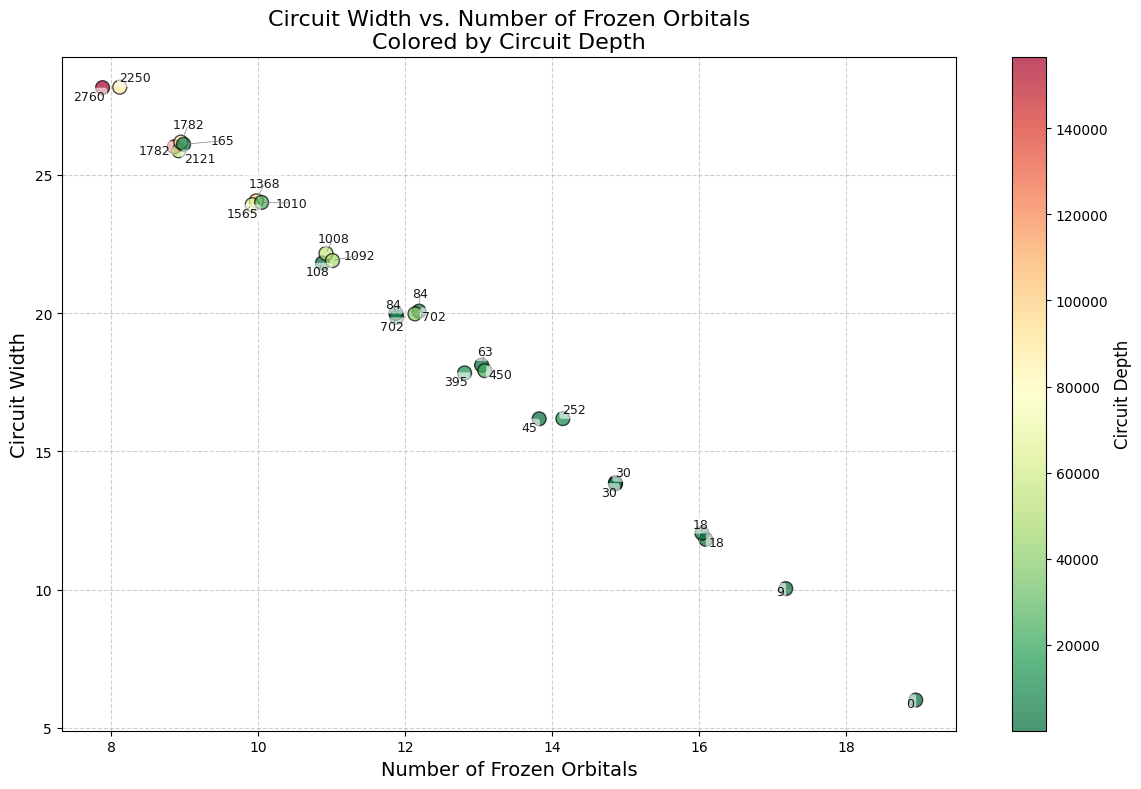

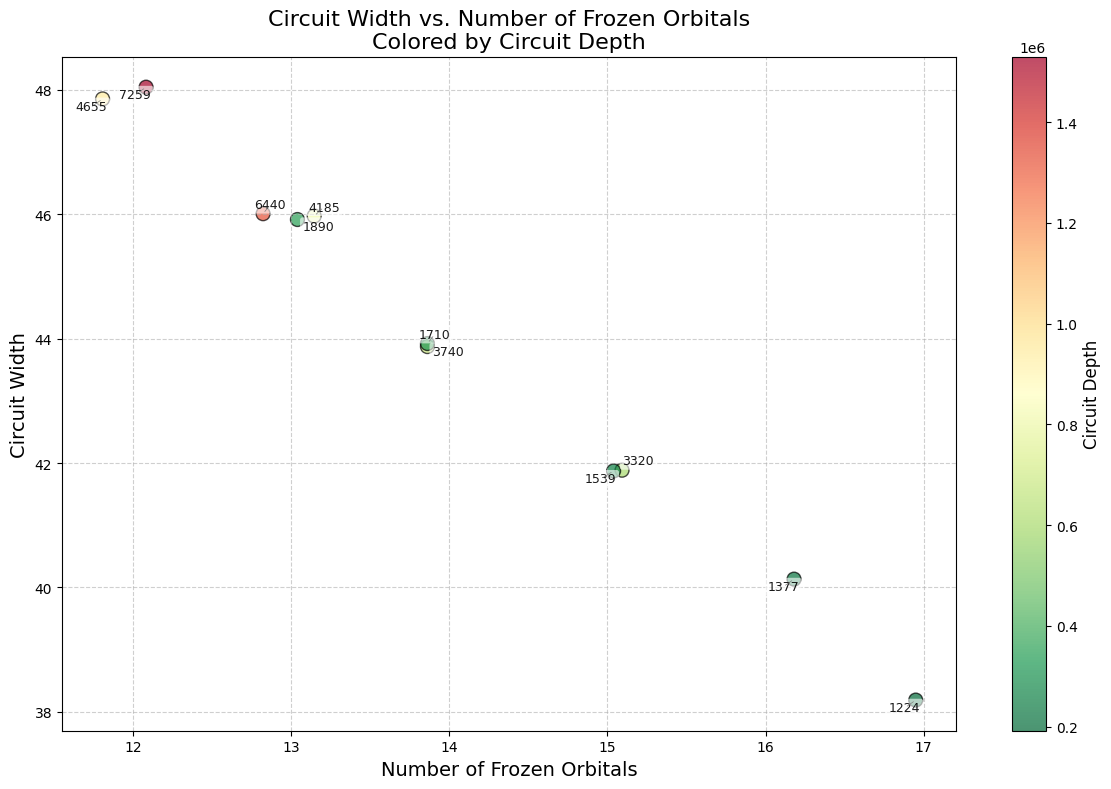

In [168]:
draw_resources(Cr_III_resources_dict)
draw_resources(Nitrate_reasources_dict)

### Executing VQE Simulations with a Time Limit
This cell initiates Variational Quantum Eigensolver (VQE) simulations for the Chromium(III) circuits as defined in the resources dictionary. The simulations begin with the least resources required and progressively increase in complexity until the specified time limit is reached. Upon completing the final successful VQE simulation, the cell also performs a classical energy calculation using the CCSD (Coupled Cluster with Single and Double excitations) solver. This classical energy serves as a reference point for the most complex circuit that was successfully run, allowing for direct comparison and validation of the VQE results. 
We will not run the Nitrate simulation in this notebook since the smallest circuit we recived is of width 38 which will require a stronger backend. We would try connecting to a backend soon and update this notebook. 

In [169]:
vqe_energies_vs_circuit_width_Cr = run_vqe_simulations(Cr_III_resources_dict, timeout_duration=240)

Running VQE simulation for circuit width 6
Function 'vqe_simulate' raised an exception: No variational gate found in the circuit.
An error occurred during VQE simulation for circuit width 6
Running VQE simulation for circuit width 10
VQE simulation successful for circuit width 10. Energy: -305.0563304941418
Running VQE simulation for circuit width 12
VQE simulation successful for circuit width 12. Energy: -305.05633049255215
Running VQE simulation for circuit width 12
VQE simulation successful for circuit width 12. Energy: -305.11635158151665
Running VQE simulation for circuit width 14
VQE simulation successful for circuit width 14. Energy: -305.04932851983637
Running VQE simulation for circuit width 14
VQE simulation successful for circuit width 14. Energy: -305.0563301858683
Running VQE simulation for circuit width 16
Function 'vqe_simulate' timed out after 240 seconds.
Stopping at circuit width 16 due to timeout.

Running classical simulation for the last successfully simulated mole

### Plotting VQE Energies vs. Circuit Width
This cell generates a scatter plot to visualize the relationship between circuit width and the ground state energies obtained from VQE simulations.

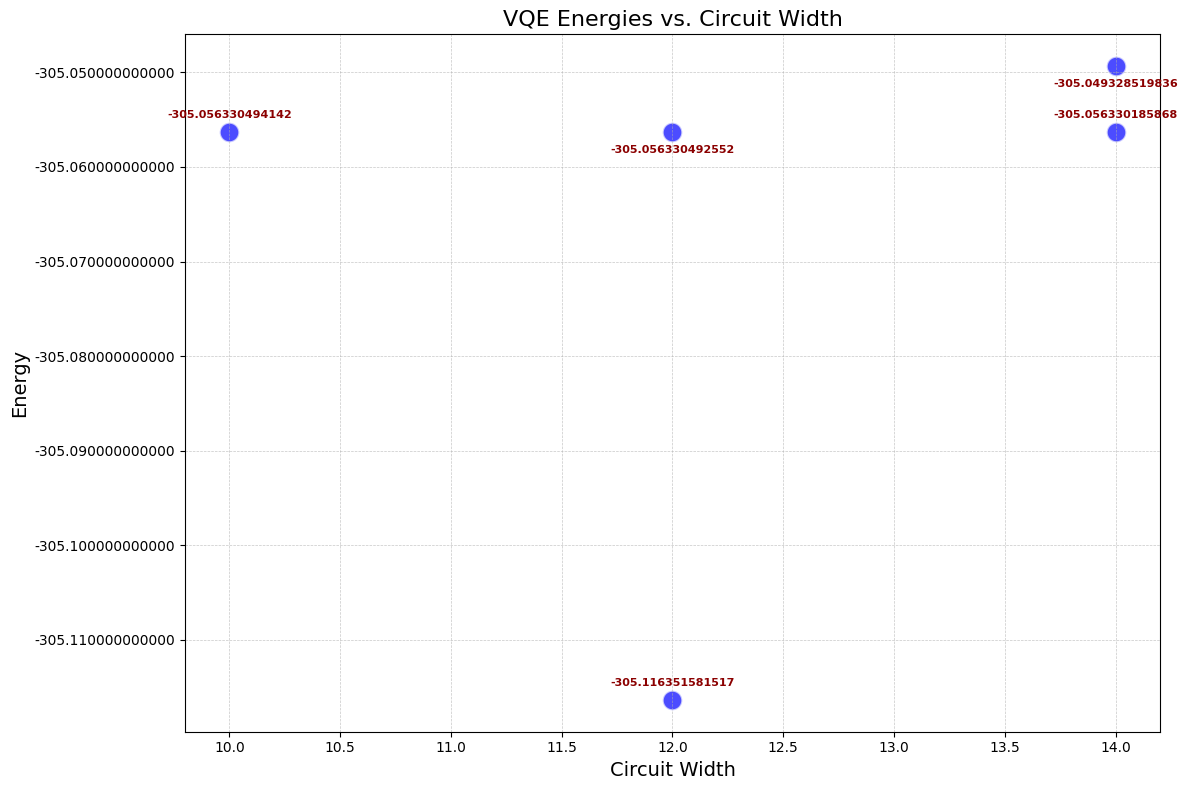

In [170]:
plot_energies_vs_circuit_width(vqe_energies_vs_circuit_width_Cr)
